   # Classification Of Venues Around Istanbul Metro Stations #

## A Coursera Data Science Capstone Project
Submitted by: Karla Marie I. De Jesus

### Introduction

   Istanbul – A bustling metropolis of 15 million people. The city of Byzantium or Constantinople, as this city was previously called, sits in the center of the world. It is a city located on the boundaries of Europe and Asia, with the Bosphorus Strait dividing the European and Asian side. Istanbul is never shy of stories to tell when it comes to history, as it has been the subject of many, many wars and rebellions just to get control of this strategic and wealthy city. From then until today, it hosts a mix of people of different cultural backgrounds, religion, even economic status. 
    
   But each of these 15 million people has places to go to, every single day. So how does Istanbul manage to move 15 million people every day? The answer mainly lies on its very effective and convenient public transportation system. Although Istanbul is also proud of its Metrobus, Bus, Ferry, Tramway and Funicular systems, this paper will only focus on Metro Lines around the city. There are, in total, 84 Metro stations around the city. There are currently six working metro lines across the metropolis, called M1, M2, M3, M4, M5 and M6. However, constructions are ongoing for M7, M8 and M9, all envisioned to be completed by 2023. 

   The Metro operates daily from 06:00- 00:00, while M1, M2, M4, M5  and M6 lines were declared to be operating at 24 hours during weekends and holidays. However, due to the Corona Virus, 24 hour operations were temporarily discontinued by the authorities. A flat fare of 3.50 TL is charged from the passenger by paying with a reloadable fare card called Istanbul Kart or by purchasing tokens from machines in metro stations. Istanbul Kart is the universal fare card in Istanbul which can also be used in busses, ferries, funiculars and trams. 

   I chose to do this study because it will be very helpful for entrepreneurs who are interested in finding the perfect spot for their intended business. By understanding the types of venues that are in a certain area, business people can easily evaluate the potentials and disadvantages of each depending on their requirements. Likewise, individuals who are looking for a good area to live or work can also find helpful insights from the clustering and classification that I will conduct throughout this study.

### Data

In [328]:
#Import necessary libraries
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [329]:
#more libraries
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium import plugins
%matplotlib inline

print('Folium and Libraries Installed')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium and Libraries Installed


The main source of data for this study is from Foursquare API, Wikipedia and the official website of Istanbul Metro, www.metro.istanbul. Mainly, I gathered the names of stations and its coordinates. 

In [330]:
#Define Foursquare credentials and version
CLIENT_ID = 'VQZAXOWR4PT3YXCIMNNO5QO22TRK1IZEYZWDAB5XMYWNIZ0E'
CLIENT_SECRET = 'JKOLPDE0D0KFIFDSGR3Z5PDYLLQSGKCAPJSTGL2LNFRAMUME'
VERSION = '20180604'
LIMIT = 100
print('Your credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentials: 
CLIENT_ID: VQZAXOWR4PT3YXCIMNNO5QO22TRK1IZEYZWDAB5XMYWNIZ0E
CLIENT_SECRET: JKOLPDE0D0KFIFDSGR3Z5PDYLLQSGKCAPJSTGL2LNFRAMUME


Let's look at the DataFrame of the different stations, lines and its coordinates.

In [331]:
df_station =pd.read_csv('ListStations.csv.csv')
df_station

,Station,Line,Latitude,Longitude,Coordinates
0,Acibadem,M4,41.006233,29.052894,"41.0062328, 29.0528941"
1,Aksaray,M1,41.008943,28.949011,"41.0089431, 28.949011499999997"
2,Altinsehir,M5,41.016534,29.137122,"41.016534, 29.137122499999997"
3,Altunizade,M5,41.018351,29.044244,"41.018350899999994, 29.044244399999997"
4,Ataturk Havalimani,M1,40.979866,28.821892,"40.9798657, 28.821891700000002"
...,...,...,...,...,...
78,Yamanevler,M5,41.026581,29.105952,"41.026581, 29.105952399999996"
79,Yenibosna,M1,40.990398,28.836084,"40.990398, 28.836084399999997"
80,Yenikapi,M1,41.004784,28.952860,"41.004784, 28.952859999999998"
81,Zeytinburnu,M1,40.993532,28.888766,"40.993531700000005, 28.888766399999998"


To get a better representation of how the different lines are in relation to the city, I plotted the stations on the map of Istanbul and I assigned them the actual colors of each line.

In [332]:
colors = {'M1': 'red', 'M2': 'green', 'M3': 'lightblue', 'M4':'pink', 'M5': 'indigo', 'M6': 'yellow'}

#create map of Istanbul with all stations
ist_lat =41.0082
ist_long= 28.9784
map_ist_metro = folium.Map(location=[ist_lat, ist_long], zoom_start=10)
df_station.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=5, fill = True, fill_opacity = 1.0,
                                              fill_color= colors[row['Line']], popup=row['Station'])
                                             .add_to(map_ist_metro), axis=1)
map_ist_metro

Exploring Venues with Foursquare API

Foursquare has many categories and even hundreds more sub categories. Although we will only be working with the Top 10 categories, the code below gets us only the 10 most popular categories.

In [333]:
import ssl
import urllib.request

#For knowing categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

#Ignore SSL Certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# make the GET request
results = requests.get(categories_url).json()
print(results)

{'meta': {'code': 200, 'requestId': '5eaea9017828ae001c3afb8a'}, 'response': {'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 'pluralName': 'Arcades', 'shortName': 'Arcade', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/a

The resulting DataFrame shows us the Top 10 categories and its corresponding Category ID

In [334]:
categories_list = []
# We are only interested in the Top-level 10 categories and category ID

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        #print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))


print_categories(results['response']['categories'], 0, 0)
#print(categories_list)

#Make a dataframe of the resulting categories
df_cat = pd.DataFrame(categories_list, columns = ['Category', 'categoryId'])
df_cat.to_csv('Top10cat.csv')
df_cat

,Category,categoryId
0,Arts & Entertainment,4d4b7104d754a06370d81259
1,College & University,4d4b7105d754a06372d81259
2,Event,4d4b7105d754a06373d81259
3,Food,4d4b7105d754a06374d81259
4,Nightlife Spot,4d4b7105d754a06376d81259
5,Outdoors & Recreation,4d4b7105d754a06377d81259
6,Professional & Other Places,4d4b7105d754a06375d81259
7,Residence,4e67e38e036454776db1fb3a
8,Shop & Service,4d4b7105d754a06378d81259
9,Travel & Transport,4d4b7105d754a06379d81259


### Methodology

Using the categories data and by using a JSON get request, we can know the venues and their count that are in a 750 meter radius of a metro station. By iterating through the different stations and their coordinates, Foursquare returns a JSON file. From this JSON, we can extract the count and venue types that we are looking for. 

In [335]:
#to get JSON of venues near metro stations
for ind in df_station.iterrows():
    latlong = df_station.loc[0,'Coordinates']
    categoryId = df_cat.loc[0,'categoryId']
    search_url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={}&v={}&radius={}&LIMIT={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latlong,
        VERSION, 
        radius, 
        LIMIT)
    json_data = requests.get(search_url).json()
 
    continue

json_data

{'meta': {'code': 200, 'requestId': '5eaeaa11f7706a001b601c34'},
 'response': {'venues': [{'id': '4d03b2f6dc45a093b4b0e5c6',
    'name': 'Ozbesa Market',
    'location': {'address': 'Acibadem basogretmen sokak',
     'lat': 41.00622726261631,
     'lng': 29.051791450375678,
     'labeledLatLngs': [{'label': 'display',
       'lat': 41.00622726261631,
       'lng': 29.051791450375678}],
     'distance': 92,
     'cc': 'TR',
     'country': 'Türkiye',
     'formattedAddress': ['Acibadem basogretmen sokak', 'Türkiye']},
    'categories': [{'id': '4d954b0ea243a5684a65b473',
      'name': 'Convenience Store',
      'pluralName': 'Convenience Stores',
      'shortName': 'Convenience Store',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/conveniencestore_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1588505086',
    'hasPerk': False},
   {'id': '54d4915e498e23ba58f214c8',
    'name': 'Acıbadem Buket Apartmanı',
    'location': {'address': '

As you can see from the result, the data we want is nestled deep into the JSON file. So I looped through the JSON, and 4 layers deep later, we can get the venue categories around each station. From here, we can already get the count of the venues.

In [337]:
#extract relevant parts of JSON to venues
venues_list = []

for venue in json_data['response']['venues']:
    #print(venue["name"])
    for cat in venue['categories']:
        whatvenue = cat['name']
        venues_list.append(whatvenue)
print(venues_list)

['Convenience Store', 'Residential Building (Apartment / Condo)', 'Shopping Mall', 'Gym / Fitness Center', 'Restaurant', 'Electronics Store', 'Park', 'Multiplex', 'Gym / Fitness Center', 'Residential Building (Apartment / Condo)', 'Park', 'Restaurant', 'Pool', 'Manti Place', 'Boutique', 'Residential Building (Apartment / Condo)', 'Outdoor Supply Store', 'Salon / Barbershop', 'Ski Area', 'Housing Development', 'Turkish Home Cooking Restaurant', 'Scenic Lookout', 'Temple', 'Residential Building (Apartment / Condo)', 'Donut Shop', 'Hookah Bar', 'Other Event', 'Residential Building (Apartment / Condo)', 'Board Shop', 'Art Gallery']


In [338]:
#get the count of venues

def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    results = requests.get(explore_url).json()['response']
    return results
print(results)

{'meta': {'code': 200, 'requestId': '5eaea9017828ae001c3afb8a'}, 'response': {'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 'pluralName': 'Arcades', 'shortName': 'Arcade', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/a

In [341]:
#Create new dataframe to store venues data
df_station_copy = df_station.copy()
for c in categories_list:
    df_station_copy[c[0]] = 0

In [ ]:
#Request number of venues, store result as CSV
for i, row in df_station_copy.iterrows():
    #print(i)
    for c in categories_list:        
        df_station_copy.loc[:, c[0]] = get_venues_count(df_station_copy.Coordinates.loc[i], radius=750, categoryId=c[1])
df_station_copy.to_csv('stations_venues.csv')

In [343]:
#Read already stored CSV
df_station_copy = pd.read_csv('stations_venues1.csv', index_col=0)
df_station_copy



,Station,Line,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Acibadem,M4,41.006233,29.052894,"41.0062328, 29.0528941",22,58,8,175,16,77,88,77,101,27
1,Aksaray,M1,41.008943,28.949011,"41.0089431, 28.949011499999997",35,105,20,208,84,87,135,17,110,138
2,Altinsehir,M5,41.016534,29.137122,"41.016534, 29.137122499999997",27,22,15,145,17,72,117,64,100,43
3,Altunizade,M5,41.018351,29.044244,"41.018350899999994, 29.044244399999997",34,85,6,172,21,88,142,49,77,49
4,Ataturk Havalimani,M1,40.979866,28.821892,"40.9798657, 28.821891700000002",13,9,5,42,4,9,83,2,30,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Yamanevler,M5,41.026581,29.105952,"41.026581, 29.105952399999996",0,0,0,0,0,0,0,0,0,0
79,Yenibosna,M1,40.990398,28.836084,"40.990398, 28.836084399999997",0,0,0,0,0,0,0,0,0,0
80,Yenikapi,M1,41.004784,28.952860,"41.004784, 28.952859999999998",0,0,0,0,0,0,0,0,0,0
81,Zeytinburnu,M1,40.993532,28.888766,"40.993531700000005, 28.888766399999998",0,0,0,0,0,0,0,0,0,0


As you can notice, the rows at the bottom has 0 number of venues. We can use the replace method (forward fill) to get the values of the previous entry instead, so our dataset is clean and has no NaN's. Now our data is clean and ready for more processing.

In [304]:
#Clean the data, fill NaN with values.
cols = ["Arts & Entertainment","College & University","Event","Food","Nightlife Spot","Outdoors & Recreation","Professional & Other Places","Residence"]
df_station_copy = df_station_copy.replace(0, method = 'ffill')
df_station_copy

,Station,Line,Latitude,Longitude,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Acibadem,M4,41.006233,29.052894,"41.0062328, 29.0528941",22.0,58.0,8.0,175.0,16.0,77.0,88.0,77.0,101,27
1,Aksaray,M1,41.008943,28.949011,"41.0089431, 28.949011499999997",35.0,105.0,20.0,208.0,84.0,87.0,135.0,17.0,110,138
2,Altinsehir,M5,41.016534,29.137122,"41.016534, 29.137122499999997",27.0,22.0,15.0,145.0,17.0,72.0,117.0,64.0,100,43
3,Altunizade,M5,41.018351,29.044244,"41.018350899999994, 29.044244399999997",34.0,85.0,6.0,172.0,21.0,88.0,142.0,49.0,77,49
4,Ataturk Havalimani,M1,40.979866,28.821892,"40.9798657, 28.821891700000002",13.0,9.0,5.0,42.0,4.0,9.0,83.0,2.0,30,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Yamanevler,M5,41.026581,29.105952,"41.026581, 29.105952399999996",46.0,101.0,18.0,250.0,103.0,78.0,136.0,13.0,150,131
79,Yenibosna,M1,40.990398,28.836084,"40.990398, 28.836084399999997",46.0,101.0,18.0,250.0,103.0,78.0,136.0,13.0,150,131
80,Yenikapi,M1,41.004784,28.952860,"41.004784, 28.952859999999998",46.0,101.0,18.0,250.0,103.0,78.0,136.0,13.0,150,131
81,Zeytinburnu,M1,40.993532,28.888766,"40.993531700000005, 28.888766399999998",46.0,101.0,18.0,250.0,103.0,78.0,136.0,13.0,150,131


I plotted the venues to visualize the data properly.

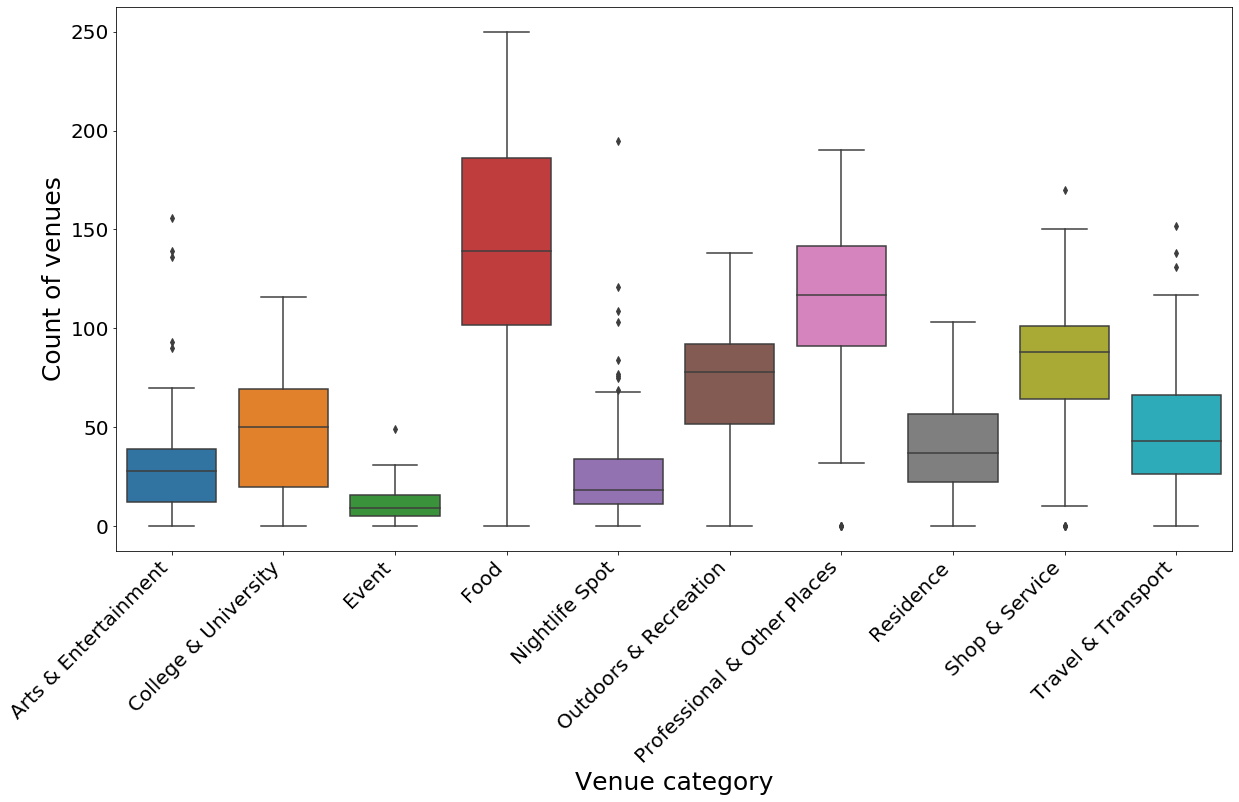

In [344]:
#Box plot of venues
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = df_station_copy.loc[:,'Arts & Entertainment':'Travel & Transport'])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

To cluster our venues into different groups, I used Standard Scaler from sklearn. This process will give our data standard values so we can cluster and compare them in a more logical way.

In [345]:
#import the needed module
from sklearn.preprocessing import StandardScaler

X = (df_station_copy.loc[:,'Arts & Entertainment':'Travel & Transport'])
cluster_dataset = StandardScaler().fit_transform(X)

In [346]:
#make a new dataframe for the standardized data
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,-0.325041,0.360405,-0.329247,0.581776,-0.390433,0.209457,-0.563234,1.671859,0.564866,-0.633795
1,0.124599,1.888600,1.048609,1.075880,1.772083,0.502625,0.511180,-0.933228,0.825493,2.708594
2,-0.152103,-0.810128,0.474503,0.132591,-0.358631,0.062872,0.099702,1.107423,0.535908,-0.152009
3,0.090011,1.238304,-0.558889,0.536858,-0.231424,0.531942,0.671199,0.456152,-0.130139,0.028660
4,-0.636331,-1.232820,-0.673711,-1.409612,-0.772054,-1.784089,-0.677534,-1.584499,-1.491191,0.811562


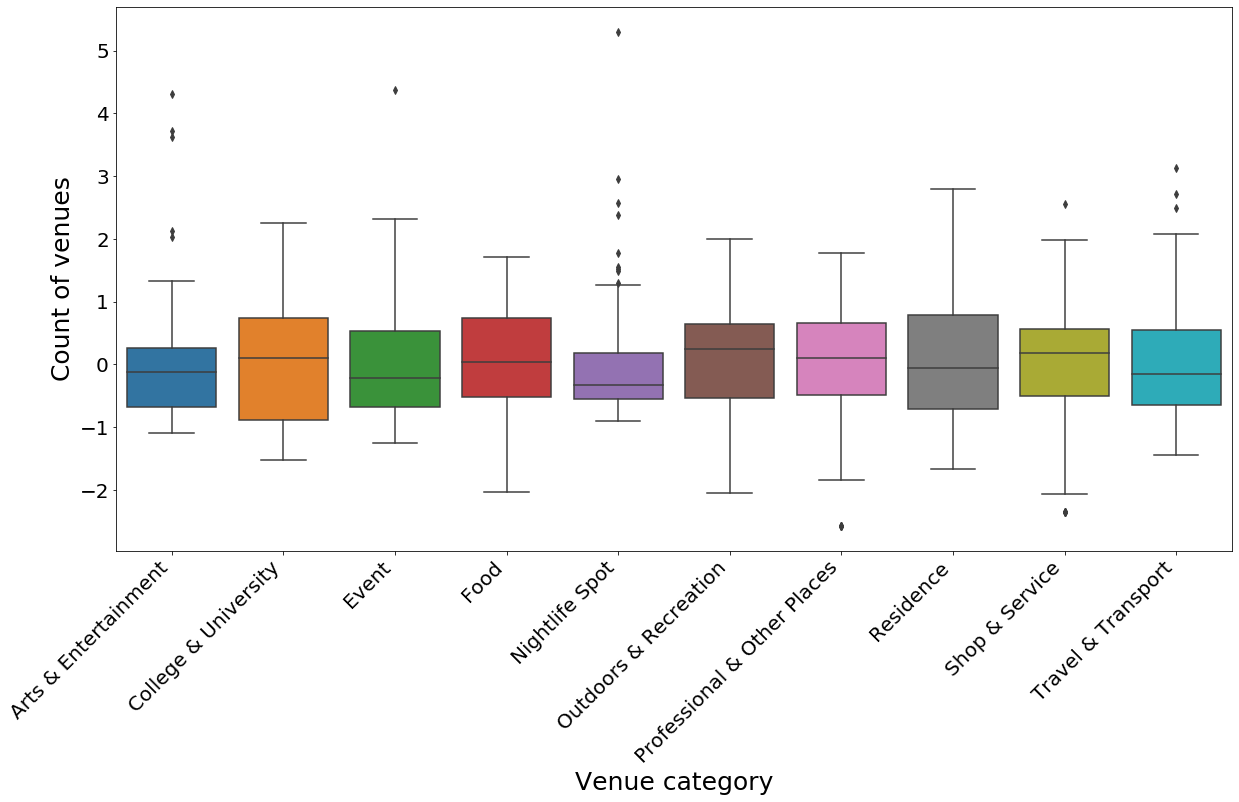

In [347]:
#Plot standardized data
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

To be able to define the proper relationships and group our data into clusters, I used the K-means Clustering Method.The goal of this algorithm is to group our data according to the assigned value of K. It assigns each data point to each K cluster based on the features similarity of each venue type.

In [361]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers(highest to lowest scores)
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = df_station_copy.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Station'] = df_station['Station']
stations_clusters_minmax_df['Coordinates'] = df_station['Coordinates']

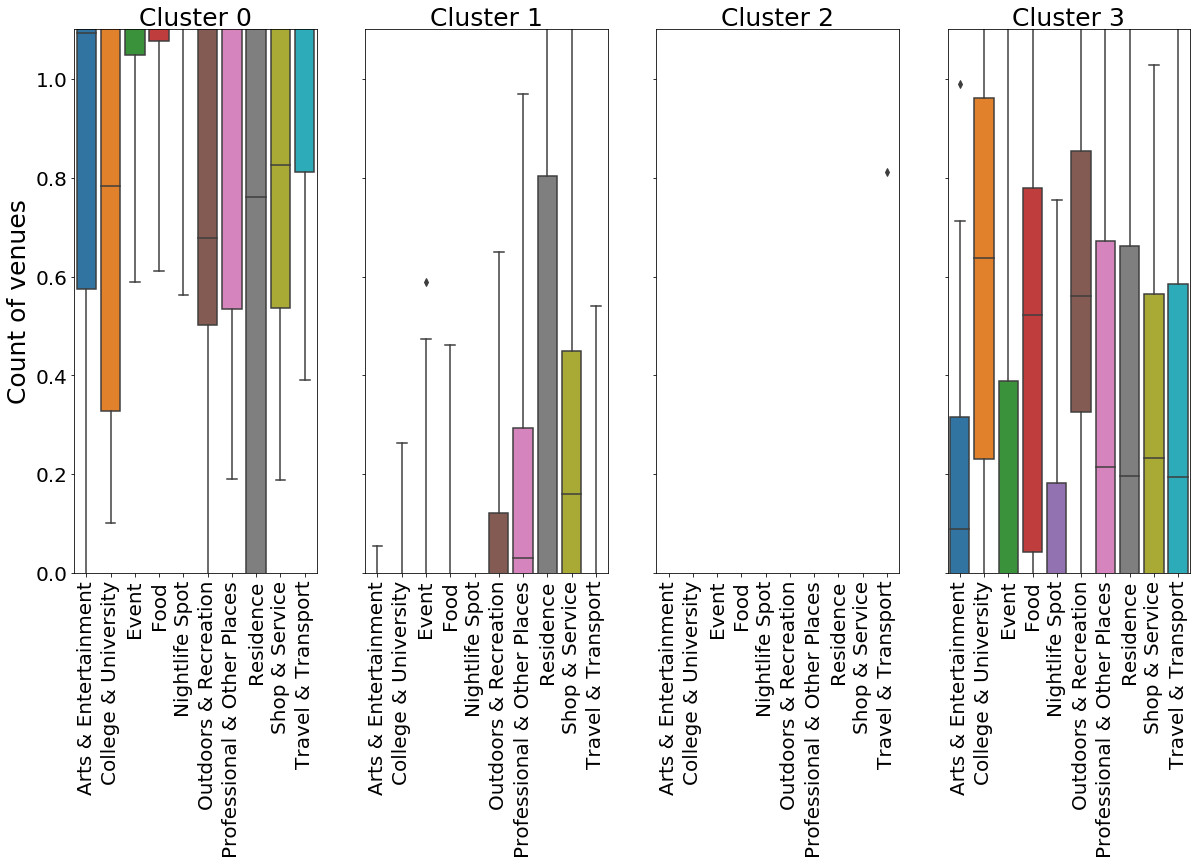

In [362]:
#plot clusters
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [364]:
#create map of Istanbul with all stations
ist_lat =41.0082
ist_long= 28.9784
map_ist_metro = folium.Map(location=[ist_lat, ist_long], zoom_start=10)

#add markers for easy visualization
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['Station'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_ist_metro)
    
map_ist_metro


### Results

Four colors represent our clusters, from highest to lowest score.
1. Blue - Areas with high venues count
2. Green - Areas with quite some venues
3. Red- Areas with not so much venues
4. Orange - Areas with very little number of venues

### Discussion

   By analyzing the results, we can identify that "Food" and "Professional and Other Places" are the most common type of venue category, while there seems to be very little under the "Event" category. It is true that Istanbul is surrounded by restaurants, cafes, pastry shops and similar areas. This is not surprising because Turks are naturally very sociable and eating and drinking tea or coffee with friends and family is their favorite pasttime. Although Istanbul is not the capital of Turkey, Istanbul is still the biggest metropolis in the country, so it is also why offices and commercial buildings is second of the most common venues.
   
   From clustering the venues data, we are able to visualize the city according to the markers on the map above. Blue markers have the highest numbers of venues. This is logical because those parts of the city marked in Blue are the busiest and considered the heart of the city. Green and Red areas are somewhat scattered just outside the perimeters of Blue markers. These green and red areas are mostly residential areas, but they still have their own share of local venues around them. The orange markers on the map are the areas with very little number of venues. This is because they are located on the outskirts of the city where not so many people live and majority of the land is not yet developed as of this time.

### Conclusion

   As conclusion to this study, it was found that Blue areas around the city are the best option for business people to establish their business. High venue counts would mean more foot traffic around the area and therefore, more possible customers for a business. Another advantage is that these venues are located walking distance from every Metro station, that would make it very accessible to people coming from all over the city. 